# Attention seq2seq - Pytorch

Dataset: http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b <br>
The goal of this notebook is to implement a seq2seq attention model and a regular seq2seq is implemented alongside to gain a more complete picture. 

## Motivating Attention

The dataset used in this notebook contains mapping of words in English and their pronounciations as a set of phoneme word pairs like so <br>
<small><p style="margin-left: 40px">S-AE1-N-AH0-T-IY0   sanity</p></small>
The task is to use a seq2seq model to learn this mapping so that given a set of phonemes, the model outputs the correct word. It can be seen as emulating spelling bee. Given below is an image of the results obtained from a regular seq2seq model
<img src="seq2seq.png">
The words inside the red square shows a common problem with seq2seq- If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. 

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import time, math
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

Path = 'data/'

## Preprocessing

In [2]:
#Get each word that begins with A-Z from each line into a list 
lines = [l.strip().split("  ") for l in open(Path+'cmudict-0.7b', encoding='latin1') 
         if re.match('^[A-Z]', l)]
#Split words and phonemes
lines = [(w, ps.split()) for w, ps in lines]
lines[0]

('A', ['AH0'])

In [3]:
#Get a list of all the unique phonemes from lines and adding _ to position 0 because it corresponds to padding
#when tokenised
phonemes = ["_"]+sorted(set(p for w, ps in lines for p in ps))
len(phonemes)

70

In [4]:
#Map phonemes to indices and letters to indices.
p2i = dict((v, k) for k, v in enumerate(phonemes))
letters = "_abcdefghijklmnopqrstuvwxyz*"
l2i = dict((v, k) for k, v in enumerate(letters))

In [5]:
#Start of sentence token
SOS_token = 0

In [6]:
maxlen = 15
#Map words to corresponding list of phoneme indices. Constraint
pronounce_dict = {w.lower(): [p2i[p] for p in ps] for w, ps in lines
                    if (5<=len(w)<=maxlen) and re.match("^[A-Z]+$", w)}
len(pronounce_dict)

108006

In [7]:
maxlen_p = max([len(v) for k,v in pronounce_dict.items()]); maxlen_p

16

In [8]:
#words contain the number of words in the filtered dictionary
words = np.random.permutation(list(pronounce_dict.keys()))
n = len(words)

#Initialise the input and labels array with zeros so that everywhere except 
#the position of values is padded
input_ = np.zeros((n, maxlen_p), np.int32)
labels_ = np.zeros((n, maxlen), np.int32)

#Fill in the non zero indices
for i, k in enumerate(words):
    for j, p in enumerate(pronounce_dict[k]): input_[i][j]=p
    for j, p in enumerate(k): labels_[i][j] = l2i[p]
        

In [9]:
#Create train, validation sets
(input_train, input_test, labels_train, labels_test, 
    ) = train_test_split(input_, labels_, test_size=0.1)

In [10]:
input_vocab_size, output_vocab_size = len(phonemes), len(letters);input_vocab_size, output_vocab_size

(70, 28)

In [11]:
dim = 240
batch_size = 128

In [12]:
def get_batch(x, y, batch_size=128):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

## Model

### Encoder

In [542]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size//2)
        self.grubi = nn.GRU(hidden_size//2, hidden_size//2, dropout=0.1, batch_first=True, num_layers=1,
                         bidirectional=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=0.1,
                            num_layers=1)
        
    def forward(self, input, hidden):
        #print ('encoder inputs input and hidden = ', input.size(), hidden.size())
        #print ('encoder embedding', (self.embedding(input)).size())
        x, hidden = self.grubi(self.embedding(input), hidden)
        #Concatenating hidden state to get a single layer because
        #bidirectional return a layer for each direction. 
        hidden = torch.cat(torch.chunk(hidden, 2, 0),2)
        output, hidden = self.gru(x, hidden)
        #print ('Encoder output-hidden = ', output.size(), hidden.size())
        return output, hidden

    # TODO: other inits
    def initHidden(self, batch_size):
        return Variable(torch.zeros(2, batch_size, self.hidden_size//2))

### Decoder

In [543]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size) #Optional
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        #emb = input
        #Comment above line and uncomment below to change decoder inputs as being
        #target values/outputs
        #print ('Decoded Input', input.size())
        emb = self.embedding(input).unsqueeze(1)
        #print ('Decoder embedded Input', emb.size())
        res, hidden = self.gru(emb, hidden)
        res, hidden = self.gru2(res, hidden)
        #print ('decoder output - hidden', res.size(), hidden.size())
        #print ('meaning of res[:,0]', res[:,0].size())
        output = self.sm(self.out(res[:,0]))
        print ('decoder ouput shape', output.size())
        return output, hidden

### Decoder with Attention

In [544]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        # end of update
        self.softmax = nn.Softmax()

    def forward(self, hidden, encoder_outputs):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers*directions,B,H)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (T,B,H)
        :return
            attention energies in shape (B,T)
        '''
        max_len = encoder_outputs.size(1)
        this_batch_size = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1)
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        return self.softmax(attn_energies).unsqueeze(1) # normalize with softmax

    def score(self, hidden, encoder_outputs):
        #print ('hidden and encoder', hidden.size(), encoder_outputs.size())
        energy = self.attn(torch.cat([hidden, encoder_outputs], 2)) # [B*T*2H]->[B*T*H]
        energy = energy.transpose(2,1) # [B*H*T]
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) #[B*1*H]
        energy = torch.bmm(v,energy) # [B*1*T]
        return energy.squeeze(1) #[B*T]

In [545]:
class Attnn(nn.Module):
    def __init__(self, hidden_size, max_length):
        super(Attn, self).__init__()
        self.maxlen = max_length
        self.hidden_size = hidden_size
        
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.other = nn.Parameter(weight_init.xavier_uniform(torch.FloatTensor(1, self.hidden_size)))
    def forward(self, hidden, encoder_outputs):
        # Create variable to store attention weights
        weights = Variable(torch.zeros(self.maxlen)).cuda()

        # Calculate energies for each encoder output
        for i in range(self.maxlen):
            attn_weights[i] = self.score(hidden, encoder_outputs[i])
        return F.softmax(attn_weights).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        weight = self.attn(torch.cat((hidden, encoder_output), 1))
        print ('weight and other', weight.size(), self.other.size())
        weight = torch.matmul(weight,other.transpose(0,1))
        print(weight.size())
        return weight



In [550]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, maxlen_p, n_layers=1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.maxlen_p = maxlen_p
        self.fix = nn.Linear(hidden_size*2, hidden_size)
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) 
        self.attn = Attn(hidden_size)
        #self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden, enc_outputs):
        emb = self.embedding(input).unsqueeze(1)
        #Variable for storing attention weights
        attn_weights = Variable(torch.zeros(self.maxlen_p)).cuda()
        #print ('encode outputs', enc_outputs.size())
        alphas = self.attn(hidden, enc_outputs)        
        #print ('alphas ', alphas.size())
        #print ('alphas are going to be bmmed with enc outputs transpose', 
        #enc_outputs.transpose(0,1).size())
        context = alphas.bmm(enc_outputs) # B x 1 x N
        #print ('emb and context going to be catted', emb.size(), context.size())
        rnn_input = torch.cat((emb, context), 2)
        rnn_input = self.fix(rnn_input)
        #print ('input to gru', rnn_input.size())
        res, hidden = self.gru(rnn_input, hidden)
        res, hidden = self.gru2(res, hidden)
        output = self.sm(self.out(res[:,0]))
        return output, hidden
    


In [535]:
other = torch.FloatTensor(1, 128, 240); other[-1].transpose(0, 1).shape

torch.Size([240, 128])

## Training

### Train loop

In [552]:
def trainattn(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_hidden = encoder_hidden
    
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    #Below code uses context vector as input to all timesteps of decoder. Comment above line
    #and uncomment below to change to this. 
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)          
        targ = target_variable[:, di]
        loss += criterion(decoder_output, targ)
        #Uncomment below to do teacher forcing
        decoder_input = targ
        #Comment above line and uncomment below to take model output as input 
        #_, indices = torch.max(decoder_output, 1)
        #decoder_input = indices
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [553]:
def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_hidden = encoder_hidden
    
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    #Below code uses context vector as input to all timesteps of decoder. Comment above line
    #and uncomment below to change to this. 
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          
        targ = target_variable[:, di]
        loss += criterion(decoder_output, targ)
        #Uncomment below to do teacher forcing
        decoder_input = targ
        #Comment above line and uncomment below to take model output as input 
        #_, indices = torch.max(decoder_output, 1)
        #decoder_input = indices
        break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [554]:
def trainIters(encoder, decoder, n_epochs, print_every=1000, plot_every=100, 
                learning_rate=0.01):


    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    criterion = nn.NLLLoss().cuda()
   
    for epoch in tqdm_notebook(range(1, n_epochs + 1)):
        training_batch = get_batch(input_train, labels_train, 128)
        input_variable = Variable(torch.LongTensor((training_batch[0].astype('int64')))).cuda()
        target_variable = Variable(torch.LongTensor(training_batch[1].astype('int64'))).cuda()
        
        loss = trainattn(input_variable, target_variable, encoder, decoder, encoder_optimizer, 
                             decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Loss: ',print_loss_avg, end="\r", flush=True)        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

### Train

In [555]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [556]:
encoder = EncoderRNN(input_vocab_size, dim).cuda()
decoder = DecoderRNN(dim, output_vocab_size).cuda()
attndecoder = AttnDecoderRNN(dim, output_vocab_size, maxlen_p).cuda()

HBox(children=(IntProgress(value=0, max=3500), HTML(value='')))

Loss:  0.15077918004989612


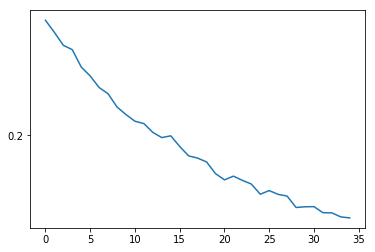

In [558]:
trainIters(encoder, attndecoder, 3500, print_every=500, learning_rate=0.0005)

In [187]:
a = torch.rand(3, 2, 4)

In [189]:
torch.transpose(a,0, 1)


(0 ,.,.) = 
  0.9820  0.9743  0.5090  0.9338
  0.7524  0.5077  0.0212  0.2963
  0.3436  0.3038  0.5135  0.6495

(1 ,.,.) = 
  0.7633  0.5293  0.5958  0.2039
  0.4689  0.9291  0.6631  0.4143
  0.7419  0.8946  0.6434  0.7140
[torch.FloatTensor of size 2x3x4]

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

encoder inputs input and hidden =  torch.Size([128, 16]) torch.Size([2, 128, 120])
encoder embedding torch.Size([128, 16, 120])
Encoder output-hidden =  torch.Size([128, 16, 240]) torch.Size([1, 128, 240])
Decoded Input torch.Size([128])
Decoder embedded Input torch.Size([128, 1, 240])
decoder output - hidden torch.Size([128, 1, 240]) torch.Size([1, 128, 240])
meaning of res[:,0] torch.Size([128, 240])
decoder ouput shape torch.Size([128, 28])



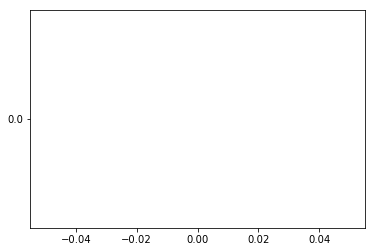

In [34]:
trainIters(encoder, decoder, 1, print_every=500, learning_rate=0.0005)

## Evaluation

In [561]:
def evaluate(encoder, decoder):  
    test_batch = get_batch(input_test, labels_test, batch_size*8)

    input_variable = Variable(torch.LongTensor((test_batch[0].astype('int64'))), volatile=True).cuda()
    target_variable = Variable(torch.LongTensor(test_batch[1].astype('int64')), volatile=True).cuda()

    _, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size*8).cuda()

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size*8), volatile=True).cuda()
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)
    decoder_hidden = encoder_hidden
    decoded_words = []
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)          
        _, indices = torch.max(decoder_output, 1)
        decoded_words.append(indices)
        decoder_input = indices
    combine = []
    for x in decoded_words:
        combine.append(x.cpu().data.numpy())
    combine = np.array(combine).T
    print ('Accuracy', np.mean([all(real==p) for real, p in zip(test_batch[1], combine)])*100,'%')
    return test_batch, combine

In [562]:
test_batch, preds = evaluate(encoder, attndecoder)

Accuracy 41.89453125 %


In [563]:
input_test=test_batch[0]
labels_test=test_batch[1]
print ('  Phonemes_________________________________predictions____________label')
for index in range(32):
    phoneme = '-'.join([phonemes[p] for p in test_batch[0][index]])
    prediction = [letters[l] for l in preds[index]]
    real = [letters[l] for l in test_batch[1][index]]
    print ('  ',phoneme.strip('-_').ljust(40), ''.join(prediction).strip('_').ljust(20), 
           ''.join(real).strip('_'))

  Phonemes_________________________________predictions____________label
   P-R-OW1-T-OW0-T-AY2-P-IH0-NG             prototyping          prototyping
   M-EY1-JH-IH0-Z                           mages                mages
   SH-ER1-Z                                 schers               scherz
   R-OW1-L-K                                rolke                roelke
   D-AW1-D-AH0-L                            dowdell              dowdell
   HH-AE1-L-K-AH0-M                         halcomb              halcomb
   Y-ER0-AA1-L-AH0-JH-AH0-S-T-S             yerologists          urologists
   S-AY1-D-AA0-R-M                          siderm               sidearm
   T-AE1-SH                                 tasch                tasch
   AE1-Z-AY2-D-Z                            asides               azides
   R-AA1-K-L-AO2                            rocklaugh            wroclaw
   S-W-IH1-N-D-AH0-L-HH-ER0-S-T             swindlearchers       swindlehurst
   D-AE1-Z-OW0                              daz

In [ ]:
torch.save(encoder, 'models/encoder.dat')
torch.save(decoder, 'models/decoder.dat')

In [ ]:
encoder = torch.load('models/encoder.dat')
decoder = torch.load('models/decoder.dat')